# Import Models and Load Data

In [52]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [57]:
from sklearn.model_selection import KFold

In [53]:
from utils import cost_function, coster, get_scores

In [54]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()
df = pd.DataFrame(cursor.execute("""select * from combined5""").fetchall())
df.columns = [description[0] for description in cursor.description]
df = df.drop(columns=["index", "level_0"])
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,plant_name_gen,operator_name_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month_nerc,number_affected,disturbance_events
0,5.4,23.100,0.0,0.49,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,259412,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
1,5.7,22.800,0.0,0.48,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,52241,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
2,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-1-SERC,0.0,0.0
3,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-1-SERC,0.0,0.0
4,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-1-SERC,0.0,0.0


In [55]:
other_fields = [ 'average_heat_content',  'average_sulfur_content',  'contract_type',  'energy_source',  'fuel_cost',  'fuel_group',   'operator_id',  'operator_name',  'plant_id',  'plant_name',  'plant_state',  'primary_transportation_mode',  'purchase_type',  'quantity',  'regulated',  'reporting_frequency',  'secondary_transportation_mode',  'supplier',   'combined_heat_and_power_plant', 'census_region',  'nerc_region',  'reserved_',  'naics_code',  'eia_sector_number',  'sector_name',  'reported_prime_mover',  'reported_fuel_type_code',   'reserved_1',  'reserved_2',  'net_generation_megawatthours', 'mmbtu_per_unit_gen',  'number_affected',  'disturbance_events']

# Checking Correlations

In [126]:
# Label encode categorical fields so that they can be correlated
df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_c[other_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_c[not_encode].reset_index()
temp2 = df_c[to_encode].apply(le.fit_transform).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [127]:
corr = df_c.corr()

In [123]:
df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]

In [124]:
df_c[ 'physical_unit_label'].value_counts()

barrels       32858
short tons     1542
mcf             244
Name: physical_unit_label, dtype: int64

In [118]:
df_c['aer_fuel_type_code'].value_counts()

DFO    30521
RFO     1925
PC      1578
WOO      459
OOG      161
Name: aer_fuel_type_code, dtype: int64

In [128]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['energy_source', 'energy_source', 1.0],
 ['average_heat_content', 'average_sulfur_content', 0.9649279649072806],
 ['average_sulfur_content', 'average_heat_content', 0.9649279649072806],
 ['average_heat_content', 'fuel_group', 0.9516121186540857],
 ['fuel_group', 'average_heat_content', 0.9516121186540857],
 ['number_affected', 'disturbance_events', 0.9143572557451818],
 ['disturbance_events', 'number_affected', 0.9143572557451818],
 ['average_sulfur_content', 'fuel_group', 0.8996131797551545],
 ['fuel_group', 'average_sulfur_content', 0.8996131797551545],
 ['naics_code', 'eia_sector_number', 0.8703864526952163],
 ['eia_sector_number', 'naics_code', 0.8703864526952163],
 ['average_heat_content', 'mmbtu_per_unit_gen', 0.7651639164569584],
 ['mmbtu_per_unit_gen', 'average_heat_content', 0.7651639164569584],
 ['eia_sector_number', 'sector_name', 0.7543181005715996],
 ['average_sulfur_content', 'mmbtu_per_unit_gen', 0.7514837871195463],
 ['mmbtu_per_unit_gen', 'average_sulfur_content', 0.

Some obvious correlations in here, like disturbance events and number affected (by disturbance events) similar for natural gas, or coalmine state and energy source, which is just coal type in this subset. It helps give an idea of the data, but it doesn't indicate any changes to features.

Heat content is interesting as it is possibly a major feature in determining fuel cost — potentially a direct gauge of fuel quality.

### Checking Correlations Involving Fuel Cost

In [129]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'primary_transportation_mode', 0.1538877195737925],
 ['fuel_cost', 'operator_name', 0.0607169736067394],
 ['fuel_cost', 'plant_name', 0.04333338360244734],
 ['fuel_cost', 'plant_state', 0.03586010108726362],
 ['fuel_cost', 'number_affected', 0.03397989455039198],
 ['fuel_cost', 'disturbance_events', 0.031381827615769166],
 ['fuel_cost', 'contract_type', 0.03097663550018397],
 ['fuel_cost', 'sector_name', 0.008104666984432008],
 ['fuel_cost', 'secondary_transportation_mode', 0.007408041900625748],
 ['fuel_cost', 'eia_sector_number', 0.006927968443166159],
 ['fuel_cost', 'naics_code', 0.003870984036544876],
 ['fuel_cost', 'purchase_type', -0.013828589877877887],
 ['fuel_cost', 'nerc_region', -0.029213310673417037],
 ['fuel_cost', 'supplier', -0.0496780870662802],
 ['fuel_cost', 'plant_id', -0.05008987844157455],
 ['fuel_cost', 'census_region', -0.05457217651780664],
 ['fuel_cost', 'reporting_frequency', -0.0591378000667756],
 ['fuel_cost', 'operator_id', -0.065797764299077

Heat and ash content decently correlated with fuel cost makes sense as those can be direct factors of fuel quality for coal. Operator may be interesting to explore later.

Chlorine content is also interesting as it involves coal and environmental regulation.

# Modelling

In [56]:
def get_c():
    df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]
    not_encode = []
    to_encode = []
    for fld, fld_type in df_c[other_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    temp1 = df_c[not_encode].reset_index()
    temp2 = pd.get_dummies(df_c[to_encode]).reset_index()
    df_c = temp1.merge(temp2, on="index").set_index("index")
    return df_c


In [64]:
def get_xy():
    X = df_c.drop(columns=["fuel_cost"])
    # Cutoff for a price spike is high - 98th percentile
    y = (df_c.fuel_cost > df_c.fuel_cost.quantile(.85))
    return X, y

In [65]:
df_c = get_c()
X, y = get_xy()

## Train/Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [67]:
results.score(X_test, y_test)

0.8520710059171598

In [68]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.7714285714285715
Recall: 0.12053571428571429
F1: 0.2084942084942085
      0    1
0  5769   40
1   985  135
Cost Function: -0.07460620941628578


Good precision, not great recall and F1. Good cost score.

Like the other sets, more false postives that true positives. But few false negatives. Potential for improvement

## KFolds

In [73]:

def get_scores(y_test, y_pred, X):
    from sklearn.metrics import f1_score, recall_score, precision_score
    precision = precision_score(y_test, y_pred)
    recall =  recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cost = cost_function(y_test, y_pred, X)
    
    print("Precision: %s" % precision)
    print("Recall: %s" % recall)
    print("F1: %s" % f1)
    print("Cost Function: %s" % cost)
    return {"precision": precision, "recall": recall, "f1": f1, "cost": cost}

In [74]:
scores = []
folds = KFold(n_splits=5, random_state=23)
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = DecisionTreeClassifier(random_state=23, max_depth=10)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    scores.append(get_scores(y_test, y_pred, X_test))

      0   1
0  5332  70
1  1493  34
Precision: 0.3269230769230769
Recall: 0.02226588081204977
F1: 0.041692213366033105
Cost Function: -0.09312140472011438
      0    1
0  6600  173
1   101   55
Precision: 0.2412280701754386
Recall: 0.3525641025641026
F1: 0.2864583333333333
Cost Function: -0.0029048861210866604
      0    1
0  6237  110
1   478  104
Precision: 0.48598130841121495
Recall: 0.17869415807560138
F1: 0.2613065326633166
Cost Function: -0.036118766236307234
      0    1
0  5020   68
1  1652  189
Precision: 0.7354085603112841
Recall: 0.10266159695817491
F1: 0.1801715919923737
Cost Function: -0.08996473764946604
      0    1
0  5678  159
1   996   95
Precision: 0.37401574803149606
Recall: 0.08707607699358387
F1: 0.1412639405204461
Cost Function: -0.05221091351158099


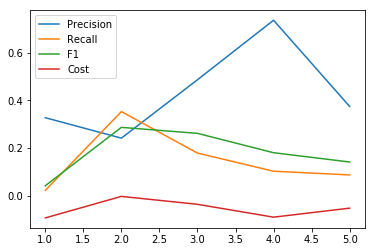

In [75]:
xs = list(range(1,6))
plt.plot(xs, [x["precision"] for x in scores], label="Precision")
plt.plot(xs, [x["recall"] for x in scores], label="Recall")
plt.plot(xs, [x["f1"] for x in scores], label="F1")
plt.plot(xs, [x["cost"] for x in scores], label="Cost")
plt.legend()

Decent cost score on just about every fold. Precision waivers between .28 and .8

## ROC Curve

In [76]:
X,y = get_xy()

In [77]:
y_pred_proba = results.predict_proba(X_test)

In [82]:
from sklearn.metrics import confusion_matrix, auc, roc_curve

In [78]:
y_pred_proba_1 = [x[1] for x in y_pred_proba]

In [83]:
pr = roc_curve(y_test, y_pred_proba_1)

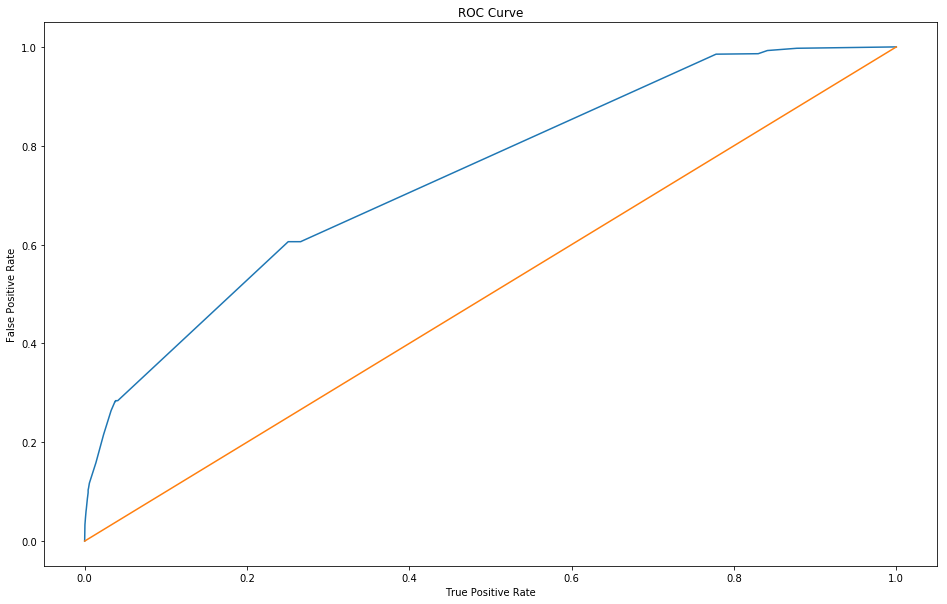

In [84]:
fig = plt.figure(figsize=(16,10))
plt.title("ROC Curve")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.plot(pr[0], pr[1])
plt.plot(pr[0],pr[0])

In [85]:
auc(pr[0], pr[1])

0.7386273789616383

## Cross Validation

In [72]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.23873873873873874
Recall: 0.05096153846153846
F1: 0.08399366085578447
      0    1
0  5721  169
1   987   53
Cost Function: -0.06149366094087367
      0    1
0  5721  169
1   987   53
Precision: 0.4511627906976744
Recall: 0.09326923076923077
F1: 0.15458167330677292
      0    1
0  5772  118
1   943   97
Cost Function: -0.07586916289812827
      0    1
0  5772  118
1   943   97
Precision: 0.975
Recall: 0.1126082771896054
F1: 0.2018981880931838
      0    1
0  5886    3
1   922  117
Cost Function: -0.0669111452858533
      0    1
0  5886    3
1   922  117
Precision: 0.07737512242899118
Recall: 0.15206929740134745
F1: 0.10256410256410256
      0     1
0  4005  1884
1   881   158
Cost Function: -0.04277523593651938
      0     1
0  4005  1884
1   881   158
Precision: 0.4092526690391459
Recall: 0.11068334937439846
F1: 0.17424242424242423
      0    1
0  5723  166
1   924  115
Cost Function: -0.05196886441358066
      0    1
0  5723  166
1   924  115


array([-0.06149366, -0.07586916, -0.06691115, -0.04277524, -0.05196886])

Not great scores here but the data set is very imbalanced with the cutoff at 98th percentile. Which also means the benefit may be minimal  - few opportunities to minimize cost

In [69]:
X_test2 = X_test[X_test["contract_type_S"] == 1]
y_test2 = y_test[X_test2.index]
y_pred = results.predict(X_test2)
get_scores(y_test2, y_pred, X_test2)

Precision: 0.7567567567567568
Recall: 0.07272727272727272
F1: 0.13270142180094785
      0   1
0  1872   9
1   357  28
Cost Function: -0.08146954022801164


In [70]:
X_test2 = X_test[X_test["contract_type_S"] != 1]
y_test2 = y_test[X_test2.index]
y_pred = results.predict(X_test2)
get_scores(y_test2, y_pred, X_test2)

Precision: 0.7753623188405797
Recall: 0.145578231292517
F1: 0.24513172966781216
      0    1
0  3897   31
1   628  107
Cost Function: -0.07305587468463597


# Trying Different Cutoffs

In [41]:
for cutoff in [.8, .85, .9, .95, .98]:
    X = df_c.drop(columns=["fuel_cost"])
    y = (df_c.fuel_cost > df_c.fuel_cost.quantile(cutoff))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    model = DecisionTreeClassifier(random_state=23)
    results = model.fit(X_train, y_train)
    get_scores(y_test, y_pred, X_test)
    

Precision: 0.23728813559322035
Recall: 0.009893992932862191
F1: 0.018995929443690638
      0   1
0  5469  45
1  1401  14
Cost Function: -0.08457467854323357
Precision: 0.2711864406779661
Recall: 0.015533980582524271
F1: 0.02938475665748393
      0   1
0  5856  43
1  1014  16
Cost Function: -0.059523090990836615
Precision: 0.1016949152542373
Recall: 0.008264462809917356
F1: 0.015286624203821656
      0   1
0  6150  53
1   720   6
Cost Function: -0.038775687772487
Precision: 0.06779661016949153
Recall: 0.011976047904191617
F1: 0.020356234096692113
      0   1
0  6540  55
1   330   4
Cost Function: -0.015189820588052376
Precision: 0.0
Recall: 0.0
F1: 0.0
      0   1
0  6740  59
1   130   0
Cost Function: -0.0018231970232086996


Seems just like a linear relationship between cutoff and cost. Precision tops out at .85 so that may be a good cutoff, but cutoff may not be the best parameter to adjust.

# Feature Analysis

In [63]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.34902638868860136
net_generation_megawatthours 0.08720992467699985
average_heat_content 0.06635480371660478
supplier_PACIFIC BIODIESEL 0.062132622808579265
average_sulfur_content 0.05156429893988355
mmbtu_per_unit_gen 0.031710250663085644
number_affected 0.011925219408571252
disturbance_events 0.010769318911442876
census_region_MTN 0.007258697900479671
contract_type_N/A 0.007245236819584759
reporting_frequency_A 0.005353884318361435
energy_source_DFO 0.00496248959779158
plant_name_Syl Laskin 0.004679688150336081
contract_type_S 0.004648459010342745
supplier_EDWARDA OIL 0.004625836154710083
plant_state_NY 0.004380404960602933
plant_id_2824 0.004168006621182126
plant_id_642 0.0040972043449264235
operator_name_City of Tallahassee 0.004094350781238758
plant_name_Hallam 0.0037501266103197035
census_region_WNC 0.003693554473927997
operator_id_10071.0 0.00368035877043231
supplier_MARATHON PETROLEUM 0.003635491803107112
supplier_NAME PENDING 0.0032628187917984643
operator_name_Black

operator_id_13478.0 0.0
operator_id_13488.0 0.0
operator_id_13683.0 0.0
operator_id_13781.0 0.0
operator_id_13994.0 0.0
operator_id_14015.0 0.0
operator_id_14063.0 0.0
operator_id_14127.0 0.0
operator_id_14232.0 0.0
operator_id_14328.0 0.0
operator_id_14354.0 0.0
operator_id_14381.0 0.0
operator_id_14605.0 0.0
operator_id_14610.0 0.0
operator_id_15143.0 0.0
operator_id_15147.0 0.0
operator_id_15248.0 0.0
operator_id_15296.0 0.0
operator_id_15472.0 0.0
operator_id_15473.0 0.0
operator_id_15474.0 0.0
operator_id_15500.0 0.0
operator_id_15776.0 0.0
operator_id_15989.0 0.0
operator_id_16572.0 0.0
operator_id_16604.0 0.0
operator_id_1692.0 0.0
operator_id_17166.0 0.0
operator_id_17177.0 0.0
operator_id_1746.0 0.0
operator_id_17543.0 0.0
operator_id_17554.0 0.0
operator_id_17568.0 0.0
operator_id_17583.0 0.0
operator_id_17632.0 0.0
operator_id_17633.0 0.0
operator_id_17698.0 0.0
operator_id_17718.0 0.0
operator_id_17828.0 0.0
operator_id_17833.0 0.0
operator_id_18315.0 0.0
operator_id_18445.

operator_name_Tri-State G & T Assn, Inc 0.0
operator_name_Tucson Electric Power Co 0.0
operator_name_UNS Electric, Inc 0.0
operator_name_Union Electric Co 0.0
operator_name_Utility Board of Key West City 0.0
operator_name_Village of Freeport 0.0
operator_name_Vineland City of 0.0
operator_name_Virginia Electric & Power Co 0.0
operator_name_WPPI Energy 0.0
operator_name_Wabash Valley Power Assn, Inc 0.0
operator_name_Westar Energy Inc 0.0
operator_name_Western Farmers Elec Coop, Inc 0.0
operator_name_Wisconsin Electric Power Co 0.0
operator_name_Wisconsin Power & Light Co 0.0
operator_name_Wisconsin Public Service Corp 0.0
operator_name_Wyandotte Municipal Serv Comm 0.0
plant_id_10 0.0
plant_id_1002 0.0
plant_id_1004 0.0
plant_id_1006 0.0
plant_id_1016 0.0
plant_id_1040 0.0
plant_id_1043 0.0
plant_id_1046 0.0
plant_id_10464 0.0
plant_id_1073 0.0
plant_id_1077 0.0
plant_id_10773 0.0
plant_id_10774 0.0
plant_id_1082 0.0
plant_id_1104 0.0
plant_id_1105 0.0
plant_id_1122 0.0
plant_id_113 0.

plant_name_Chesapeake 0.0
plant_name_Chesterfield 0.0
plant_name_Chevron Oil 0.0
plant_name_Chillicothe 0.0
plant_name_Cholla 0.0
plant_name_Clay Boswell 0.0
plant_name_Cleary Flood 0.0
plant_name_Cliffside 0.0
plant_name_Clifton 0.0
plant_name_Clinch River 0.0
plant_name_Coffeyville 0.0
plant_name_Colbert 0.0
plant_name_Columbia Energy Center (SC) 0.0
plant_name_Colusa Generating Station 0.0
plant_name_Comanche 0.0
plant_name_Comanche (OK) 0.0
plant_name_Commonwealth Atlantic LP 0.0
plant_name_Concord 0.0
plant_name_Conesville 0.0
plant_name_Connersville 0.0
plant_name_Cooper 0.0
plant_name_Coronado 0.0
plant_name_Coyote 0.0
plant_name_Crist 0.0
plant_name_Cumberland 0.0
plant_name_Cumberland (TN) 0.0
plant_name_D B Wilson 0.0
plant_name_Dale 0.0
plant_name_Dan E Karn 0.0
plant_name_Dan River 0.0
plant_name_Darbytown 0.0
plant_name_Darlington County 0.0
plant_name_Davant Transfer 0.0
plant_name_Dave Gates Generating Station 0.0
plant_name_DeBary 0.0
plant_name_Deerhaven Generating Sta

supplier_BIOENERGY SOLUTIONS 0.0
supplier_BLACKJEWEL MARKETING AND SALES, LLC. 0.0
supplier_BOMINFLOT ATLANTIC 0.0
supplier_BOSWELL 0.0
supplier_BP 0.0
supplier_BP NORTH AMERICA 0.0
supplier_BPE 0.0
supplier_BRADCO FUELS & LUBRICANTS 0.0
supplier_BRAUN OIL COMPANY 0.0
supplier_BRICK JEDA OIL CO 0.0
supplier_BRIGGS & TILLMAN 0.0
supplier_BUCKLEY 0.0
supplier_BULK PLANTS 0.0
supplier_BULLOCK OIL 0.0
supplier_BUMPERS OIL 0.0
supplier_BV OIL CO 0.0
supplier_BV OIL COMPANY 0.0
supplier_C STODDARD & SONS 0.0
supplier_CAPEX 0.0
supplier_CAPITAL CITY OIL 0.0
supplier_CARDWELL DISTRIBUTING 0.0
supplier_CARGILL 0.0
supplier_CARSON OIL 0.0
supplier_CARTER PERTOLEUM 0.0
supplier_CASTAGNO OIL CO.,Inc. 0.0
supplier_CASTLETON COMMODITIES INTERNATIONAL LLC 0.0
supplier_CASTLETON COMMODITIES MERCHANT TRADING LP 0.0
supplier_CENEX OF HAZEN 0.0
supplier_CENTRAL OIL 0.0
supplier_CHASEBURG FARMER'S UNION 0.0
supplier_CHEMOIL 0.0
supplier_CHEMOIL CORPORATION 0.0
supplier_CHIEF PETROLEUM 0.0
supplier_CHRISTM

# Removing Features

In [37]:
updated_fields = list(X.columns)
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    if b == 0:
        updated_fields.remove(a)

In [39]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train[updated_fields], y_train)

cross_val_score(results, X[updated_fields], y, scoring=coster, cv=5)

Precision: 0.2978723404255319
Recall: 0.10071942446043165
F1: 0.15053763440860216
      0   1
0  6758  33
1   125  14
Cost Function: -0.002748012333072588
      0   1
0  6758  33
1   125  14
Precision: 0.125
Recall: 0.02158273381294964
F1: 0.03680981595092025
      0   1
0  6769  21
1   136   3
Cost Function: -0.01545345151824095
      0   1
0  6769  21
1   136   3
Precision: 1.0
Recall: 0.22302158273381295
F1: 0.3647058823529412
      0   1
0  6790   0
1   108  31
Cost Function: -0.004236313524199726
      0   1
0  6790   0
1   108  31
Precision: 0.5580110497237569
Recall: 0.7318840579710145
F1: 0.6332288401253919
      0    1
0  6710   80
1    37  101
Cost Function: -0.00021043154108768268
      0    1
0  6710   80
1    37  101
Precision: 0.9710144927536232
Recall: 0.4855072463768116
F1: 0.6473429951690821
      0   1
0  6788   2
1    71  67
Cost Function: -0.0004138685315819881
      0   1
0  6788   2
1    71  67


array([-0.00274801, -0.01545345, -0.00423631, -0.00021043, -0.00041387])

In [40]:
y_pred = results.predict(X_test[updated_fields])
get_scores(y_test, y_pred, X_test[updated_fields])

Precision: 0.8813559322033898
Recall: 0.3795620437956204
F1: 0.5306122448979592
      0   1
0  6785   7
1    85  52
Cost Function: -0.0026992421993909284


Still not great scores without those features, although few false negatives. Looking at other options.

# Parameter Tuning

In [64]:
#from sklearn.metrics import make_scorer
scorer = make_scorer(f1_score)
cross_val_score(results, X, y, cv=5, scoring=scorer)

array([0.33280255, 0.27766032, 0.27586207, 0.17618271, 0.2057735 ])

In [52]:
from sklearn.metrics import roc_curve, auc

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [55]:
roc_auc = auc(fpr, tpr)
roc_auc

0.6712025165949872

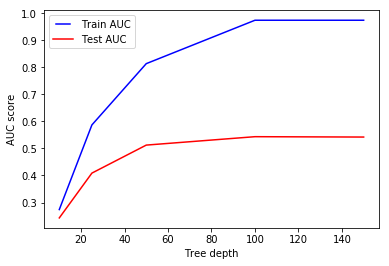

In [75]:
max_depths = [10, 25, 50, 100, 150]

train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
    
    train_results.append(f1_score(y_train, y_pred))
    
    
    y_pred = dt.predict(X_test)
    
    # Add auc score to previous test results
    test_results.append(f1_score(y_test, y_pred))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [ ]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results = []
for min_sample in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_sample)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
    
    train_results.append(f1_score(y_train, y_pred))
    
    
    y_pred = dt.predict(X_test)
    
    # Add auc score to previous test results
    test_results.append(f1_score(y_test, y_pred))
    


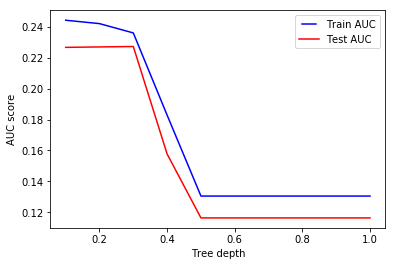

In [77]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [79]:
X_train.shape[1]

2030

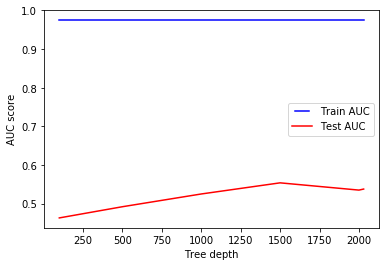

In [80]:
max_features = [100, 500, 1000, 1500, 2000, 2030]

train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
    
    train_results.append(f1_score(y_train, y_pred))
    
    
    y_pred = dt.predict(X_test)
    
    # Add auc score to previous test results
    test_results.append(f1_score(y_test, y_pred))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


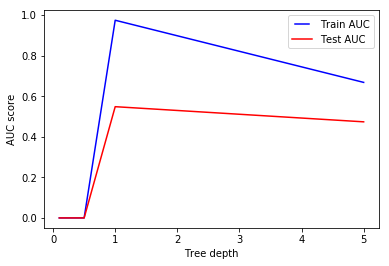

In [84]:
min_samples_leafs = [0.1, 0.5, 1, 5]

train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
    
    train_results.append(f1_score(y_train, y_pred))
    
    
    y_pred = dt.predict(X_test)
    
    # Add auc score to previous test results
    test_results.append(f1_score(y_test, y_pred))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [89]:
dt = DecisionTreeClassifier(max_features=1500, max_depth=50)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
f1_score(y_test, y_pred)

0.48915871639202085

# Analyze False Positives and Negatives

In [13]:
# Reload data label-encoded for correlation
# Label encode categorical fields so that they can be correlated
df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]

not_encode = []
to_encode = []
for fld, fld_type in df_c[other_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_c[not_encode].reset_index()
temp2 = df_c[to_encode].apply(le.fit_transform).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [14]:
y_pred = results.predict(X)

In [15]:
wrongs = (y_pred != y)

### Append the wrong flag on the dataframe so we can analyze and subset

In [16]:
df_c["wrong"] = wrongs

In [17]:
df_c = df_c[df_c["wrong"] == True].drop(columns="wrong")

### Correlations on the Dataset of Innaccurate Predictions

In [19]:
corr = df_c.corr()
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'purchase_type', 0.06739711609842206],
 ['fuel_cost', 'plant_state', 0.05455218373798558],
 ['fuel_cost', 'operator_name', 0.05241113709977823],
 ['fuel_cost', 'plant_id', 0.044450606592372474],
 ['fuel_cost', 'primary_transportation_mode', 0.02800176490850665],
 ['fuel_cost', 'net_generation_megawatthours', 0.020258081002397673],
 ['fuel_cost', 'mmbtu_per_unit_gen', 0.01771539871132474],
 ['fuel_cost', 'energy_source', 0.005959252099399856],
 ['fuel_cost', 'reported_fuel_type_code', 0.005959252099399856],
 ['average_heat_content', 'fuel_cost', 0.002885470720747976],
 ['fuel_cost', 'average_heat_content', 0.002885470720747976],
 ['fuel_cost', 'operator_id', 0.0025806487057165443],
 ['fuel_cost', 'number_affected', -0.004025213609524104],
 ['fuel_cost', 'combined_heat_and_power_plant', -0.005461700570366014],
 ['fuel_cost', 'disturbance_events', -0.007655949375038832],
 ['fuel_cost', 'reporting_frequency', -0.011989497143962934],
 ['fuel_cost', 'secondary_transportation_m

Largest correlation of inaccurate predictions involves chlorine content. But looking at other top correlations too.

In [149]:
df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]

In [151]:
df_c["wrong"] = wrongs

In [175]:
df_c[df_c["wrong"]== True]["contract_type"].value_counts()/len(df_c[df_c["wrong"]== True])

S      0.640212
C      0.193496
N/A    0.165808
NC     0.000483
Name: contract_type, dtype: float64

In [173]:
df_c[(df_c["wrong"]== True) & (df_c["energy_source"] == "DFO")].head(100)

,average_heat_content,average_sulfur_content,contract_type,energy_source,fuel_cost,fuel_group,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,combined_heat_and_power_plant,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,reserved_1,reserved_2,net_generation_megawatthours,mmbtu_per_unit_gen,number_affected,disturbance_events,wrong
74,5.544,0.30,S,DFO,2209.0,Petroleum,213.0,Alaska Electric Light&Power Co,64,Lemon Creek,AK,TR,N/A,9196,REG,M,N/A,NAME PENDING,N,PACN,ASCC,None,22,1,Electric Utility,GT,DFO,None,None,5066,0.00,0.0,0.0,True
75,5.544,0.30,S,DFO,2209.0,Petroleum,213.0,Alaska Electric Light&Power Co,64,Lemon Creek,AK,TR,N/A,9196,REG,M,N/A,NAME PENDING,N,PACN,ASCC,None,22,1,Electric Utility,IC,DFO,None,None,23297,5.54,0.0,0.0,True
91,5.820,0.00,S,DFO,2188.6,Petroleum,15500.0,Puget Sound Energy Inc,99,Frederickson,WA,TR,N/A,958,REG,A,TR,DON SMALL & SONS OIL DISTRIBUTION CO,N,PACC,WECC,None,22,1,Electric Utility,GT,DFO,None,None,5354,5.53,0.0,0.0,True
180,5.800,0.35,C,DFO,1891.3,Petroleum,9617.0,JEA,207,St Johns River Power Park,FL,TR,N/A,2170,REG,M,N/A,COLONIAL OIL,N,SAT,FRCC,None,22,1,Electric Utility,ST,DFO,None,None,21066,5.76,0.0,0.0,True
313,5.800,0.10,S,DFO,1961.7,Petroleum,14610.0,Orlando Utilities Comm,564,Stanton Energy Center,FL,TR,N/A,533,REG,M,N/A,ROYAL PETROLEUM,N,SAT,FRCC,None,22,1,Electric Utility,ST,DFO,None,None,0,0.00,0.0,0.0,True
363,5.824,0.00,C,DFO,1934.4,Petroleum,7801.0,Gulf Power Co,643,Lansing Smith,FL,TR,N/A,181,REG,M,N/A,Petroleum Traders,N,SAT,SERC,None,22,1,Electric Utility,GT,DFO,None,None,124,5.82,0.0,0.0,True
395,5.796,0.06,S,DFO,1933.9,Petroleum,10623.0,City of Lakeland,675,Larsen Memorial,FL,TR,N/A,149,REG,A,N/A,FLEETWING,N,SAT,FRCC,None,22,1,Electric Utility,CA,DFO,None,None,388,0.00,0.0,0.0,True
480,5.800,0.01,S,DFO,1894.2,Petroleum,17828.0,City of Springfield - (IL),964,Lakeside,IL,TR,N/A,177,REG,A,N/A,MANSFIELD,N,ENC,SERC,None,22,1,Electric Utility,IC,DFO,None,None,0,0.00,0.0,0.0,True
481,5.800,0.01,S,DFO,1894.2,Petroleum,17828.0,City of Springfield - (IL),964,Lakeside,IL,TR,N/A,177,REG,A,N/A,MANSFIELD,N,ENC,SERC,None,22,1,Electric Utility,ST,DFO,None,None,656,5.80,0.0,0.0,True
498,5.712,0.30,S,DFO,2102.4,Petroleum,9269.0,Indiana-Kentucky Electric Corp,983,Clifty Creek,IN,TR,N/A,1096,REG,M,N/A,Key Oil,N,ENC,RFC,None,22,1,Electric Utility,ST,DFO,None,None,4499,0.00,0.0,0.0,True


In [174]:
df_c["contract_type"].value_counts()

N/A    14909
S      11399
C       8252
NC        84
Name: contract_type, dtype: int64

In [160]:
df_c["plant_state"].value_counts()[0:10]/len(df_c)

MI    0.106801
HI    0.087144
FL    0.081544
KY    0.071008
IN    0.056142
MO    0.049128
NC    0.042432
VA    0.038390
SC    0.037698
OH    0.030308
Name: plant_state, dtype: float64

In [159]:
df_c[df_c["wrong"]== True]["plant_state"].value_counts()/len(df_c[df_c["wrong"]== True])

MI    0.167257
FL    0.098680
OH    0.067289
IN    0.054411
CO    0.053284
MO    0.050386
HI    0.041050
IA    0.040889
MN    0.033323
KY    0.030586
ND    0.029942
NY    0.027366
TX    0.025435
AK    0.022376
WV    0.021893
WY    0.018030
SC    0.017547
NM    0.017386
GA    0.016581
AZ    0.015937
NC    0.014166
WI    0.013844
UT    0.013200
KS    0.012395
NE    0.011751
NH    0.011269
OK    0.009337
VA    0.009176
MT    0.009176
MA    0.008371
IL    0.008210
AL    0.005151
NV    0.004668
OR    0.003381
TN    0.003220
LA    0.003220
WA    0.002576
CA    0.002254
AR    0.001771
SD    0.001449
CT    0.000644
NJ    0.000483
VT    0.000322
MS    0.000322
Name: plant_state, dtype: float64

# Subsetting the data - Only Spot Contracts

In [42]:
df_c = get_c()
df_c2 = df_c[(df_c["contract_type_S"] ==1)].copy()

X = df_c2.drop(columns="fuel_cost")
y = (df_c2.fuel_cost > df_c.fuel_cost.quantile(.85))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23)
results = model.fit(X_train, y_train, sample_weight=X_train.quantity)

In [43]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.6460674157303371
Recall: 0.5897435897435898
F1: 0.6166219839142091
      0    1
0  1764  126
1   160  230
Cost Function: -0.05288341249424607


In [44]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.24880838894184937
Recall: 0.7209944751381215
F1: 0.369950389794472
      0    1
0  1130  788
1   101  261
Cost Function: -0.038540820208826536
      0    1
0  1130  788
1   101  261
Precision: 0.4010989010989011
Recall: 0.40331491712707185
F1: 0.40220385674931125
      0    1
0  1700  218
1   216  146
Cost Function: -0.09749423244037501
      0    1
0  1700  218
1   216  146
Precision: 0.15244596131968147
Recall: 0.3701657458563536
F1: 0.21595487510072525
      0    1
0  1173  745
1   228  134
Cost Function: -0.04634617791046264
      0    1
0  1173  745
1   228  134
Precision: 0.3319327731092437
Recall: 0.21823204419889503
F1: 0.2633333333333333
      0    1
0  1759  159
1   283   79
Cost Function: -0.04206850764635824
      0    1
0  1759  159
1   283   79
Precision: 0.215625
Recall: 0.7645429362880887
F1: 0.3363802559414992
     0     1
0  914  1004
1   85   276
Cost Function: -0.07289658209356202
     0     1
0  914  1004
1   85   276


array([-0.03854082, -0.09749423, -0.04634618, -0.04206851, -0.07289658])

Much better scores here than on the full data set.

In [46]:
133/5

26.6

In [45]:
np.mean([-0.03854082, -0.09749423, -0.04634618, -0.04206851, -0.07289658])

-0.059469264

In [35]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.35964884345590503
average_sulfur_content 0.07676006185624322
net_generation_megawatthours 0.06961631788770827
average_heat_content 0.05828101482860516
mmbtu_per_unit_gen 0.02572334226048783
operator_name_City of Tallahassee 0.012607957018764476
plant_id_2265 0.010857524474906934
plant_id_1832 0.009967433924079618
census_region_MTN 0.009451446305285043
plant_name_Haefling 0.009208434300978167
supplier_SILVAS 0.009187551129868132
number_affected 0.009177924888690191
supplier_EDWARDA OIL 0.009118235229398601
reported_prime_mover_ST 0.007697831480397715
operator_id_213.0 0.00749282640492368
supplier_SOUTHWEST GEORGIA OIL 0.007425144631604707
disturbance_events 0.007413236609472384
operator_id_17583.0 0.0073333810072249
supplier_WARNER PETROLEUM 0.006762309564312092
supplier_INDIGO ENERGY 0.006389604062603404
supplier_HERITAGE PETROLEUM 0.006310857881263884
supplier_IPC USA 0.005674428514435636
supplier_FOLK OIL COMPANY 0.005580877465865542
supplier_FLEETWING 0.005577860559088247

operator_name_Los Angeles Department of Water & Power 0.0
operator_name_Lower Colorado River Authority 0.0
operator_name_Madison Gas & Electric Co 0.0
operator_name_Manitowoc Public Utilities 0.0
operator_name_Massachusetts Mun Wholes Electric Co 0.0
operator_name_Maui Electric Co Ltd 0.0
operator_name_Michigan South Central Power Agency 0.0
operator_name_MidAmerican Energy Co 0.0
operator_name_Minnesota Municipal Power Agny 0.0
operator_name_Minnkota Power Coop, Inc 0.0
operator_name_Mississippi Power Co 0.0
operator_name_Missouri Basin Muni Power Agny 0.0
operator_name_Modesto Irrigation District 0.0
operator_name_Monongahela Power Co 0.0
operator_name_Morgan City - (LA) 0.0
operator_name_National Grid Generation LLC 0.0
operator_name_National Power Coop Inc 0.0
operator_name_New Ulm Public Utilities Comm 0.0
operator_name_North Carolina El Member Corp 0.0
operator_name_NorthWestern Energy DGGS 0.0
operator_name_Northern States Power Co - Minnesota 0.0
operator_name_Oglethorpe Power 

plant_name_Belews Creek 0.0
plant_name_Belle River 0.0
plant_name_Bellmeade Power Station 0.0
plant_name_Ben French 0.0
plant_name_Big Bend 0.0
plant_name_Black Dog 0.0
plant_name_Black River Generation 0.0
plant_name_Blue Spruce Energy Center 0.0
plant_name_Blue Valley 0.0
plant_name_Boardman 0.0
plant_name_Bonanza 0.0
plant_name_Bowen 0.0
plant_name_Brame Energy Center 0.0
plant_name_Brandy Branch 0.0
plant_name_Bremo Bluff 0.0
plant_name_Buck 0.0
plant_name_Bull Run 0.0
plant_name_Burlington 0.0
plant_name_Burlington (IA) 0.0
plant_name_Butler-Warner Generation Plant 0.0
plant_name_C D McIntosh Jr 0.0
plant_name_C W Burdick 0.0
plant_name_Cambridge CT 0.0
plant_name_Campbell Indust. Park Generating Station 0.0
plant_name_Campbell Industrial Park 0.0
plant_name_Canaday 0.0
plant_name_Canadys Steam 0.0
plant_name_Cane Run 0.0
plant_name_Cape Canaveral 0.0
plant_name_Cape Fear 0.0
plant_name_Carbon 0.0
plant_name_Cardinal 0.0
plant_name_Cayuga 0.0
plant_name_Cecil Lynch 0.0
plant_name_

supplier_Diversified Energy 0.0
supplier_EAST RIVER ENERGY 0.0
supplier_EDWARDS ETHERTON 0.0
supplier_ELEMENT MARKETS 0.0
supplier_ENERBASE COOPERATIVE RESOURCES 0.0
supplier_ENERGY 0.0
supplier_ENVIRONMENTAL DEVELOPMENT GROUP 0.0
supplier_EQUITABLE 0.0
supplier_EQUITABLE OIL 0.0
supplier_EXXON 0.0
supplier_EXXONMOBIL 0.0
supplier_FAISER OIL 0.0
supplier_FARSTAD 0.0
supplier_FCC ENVIRONMENTAL 0.0
supplier_FERRELL GAS 0.0
supplier_FISCHER OIL CO 0.0
supplier_FISHER 0.0
supplier_FITTERER OIL COMPANY 0.0
supplier_FLINT HILLS RESOURCES 0.0
supplier_FLYERS ENERGY 0.0
supplier_FORELAND REFINERY 0.0
supplier_FREEPOINT COMMODITIES LLC 0.0
supplier_FRENCHMAN VALLEY COOP 0.0
supplier_FRETTE ENERGY 0.0
supplier_FUEL MANAGERS 0.0
supplier_FUEL MASTERS LLC 0.0
supplier_FUEL OIL-PSO 0.0
supplier_FUEL OIL-SWEPCO 0.0
supplier_FUSER OIL 0.0
supplier_FrankThomp 0.0
supplier_FuelMaster 0.0
supplier_G P RESOURCES 0.0
supplier_GA TANK LINES 0.0
supplier_GARROW OIL & PROPANE 0.0
supplier_GARY WILLIAMS ENERG

In [18]:
leaf1_test = y_test
leaf1_pred = y_pred

Some abberations in cross_val_score. Spot contracts for petroleum may be particularly volatile and hard to predict.

# Modeling Subset of Data - No Spot Contracts

In [47]:
df_c = get_c()
df_c3 = df_c[(df_c["contract_type_S"] != 1)]

X = df_c3.drop(columns="fuel_cost")
y = (df_c3.fuel_cost > df_c.fuel_cost.quantile(.85))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(max_depth=10)
results = model.fit(X_train, y_train)

In [48]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)


Precision: 0.6981132075471698
Recall: 0.2141823444283647
F1: 0.327796234772979
      0    1
0  3894   64
1   543  148
Cost Function: -0.06920807785110598


In [49]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.4
Recall: 0.07079646017699115
F1: 0.12030075187969924
      0   1
0  3900  72
1   630  48
Cost Function: -0.06321477006754066
      0   1
0  3900  72
1   630  48
Precision: 0.6894736842105263
Recall: 0.19321533923303835
F1: 0.30184331797235026
      0    1
0  3913   59
1   547  131
Cost Function: -0.0836377409835099
      0    1
0  3913   59
1   547  131
Precision: 0.5078125
Recall: 0.09587020648967552
F1: 0.16129032258064518
      0   1
0  3908  63
1   613  65
Cost Function: -0.08360311119654194
      0   1
0  3908  63
1   613  65
Precision: 0.13859910581222057
Recall: 0.13737075332348597
F1: 0.13798219584569735
      0    1
0  3393  578
1   584   93
Cost Function: -0.04099991309527278
      0    1
0  3393  578
1   584   93
Precision: 0.3532934131736527
Recall: 0.17429837518463812
F1: 0.23343224530168152
      0    1
0  3755  216
1   559  118
Cost Function: -0.0396416154979628
      0    1
0  3755  216
1   559  118


array([-0.06321477, -0.08363774, -0.08360311, -0.04099991, -0.03964162])

In [51]:
206/5

41.2

In [50]:
np.mean([-0.06321477, -0.08363774, -0.08360311, -0.04099991, -0.03964162])

-0.06221943

In [24]:
leaf2_pred = y_pred
leaf2_test = y_test

In [22]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.37950506944760193
net_generation_megawatthours 0.08108923995844071
average_sulfur_content 0.08063498349683909
average_heat_content 0.05052689879763082
mmbtu_per_unit_gen 0.02887588404982176
operator_name_City of Tallahassee 0.011715487212606757
number_affected 0.011077804509097023
supplier_EDWARDA OIL 0.009939263389092748
census_region_MTN 0.00836653305733368
plant_name_Hallam 0.008280539390707813
plant_id_1832 0.008257959426983898
supplier_FOLK OIL COMPANY 0.007630589935633191
reported_prime_mover_GT 0.007555315677779629
supplier_SOUTHWEST GEORGIA OIL 0.007403496883801003
plant_name_Haefling 0.007390037509850728
supplier_SILVAS 0.007376614805779637
operator_id_17583.0 0.007148232356323485
plant_id_64 0.007144679775730939
supplier_WARNER PETROLEUM 0.0069834225807704695
supplier_FRAZIER OIL CO 0.006756349571005401
census_region_SAT 0.006252087622769609
operator_id_19545.0 0.0060652343310786585
plant_name_West Phoenix 0.005623006135853086
supplier_FLEETWING 0.00555665531515009

plant_id_1710 0.0
plant_id_1720 0.0
plant_id_1723 0.0
plant_id_1729 0.0
plant_id_173 0.0
plant_id_1731 0.0
plant_id_1733 0.0
plant_id_1734 0.0
plant_id_1740 0.0
plant_id_1743 0.0
plant_id_1744 0.0
plant_id_1745 0.0
plant_id_1769 0.0
plant_id_1831 0.0
plant_id_1843 0.0
plant_id_1866 0.0
plant_id_1888 0.0
plant_id_1891 0.0
plant_id_1904 0.0
plant_id_1913 0.0
plant_id_1915 0.0
plant_id_1927 0.0
plant_id_1943 0.0
plant_id_2001 0.0
plant_id_201 0.0
plant_id_203 0.0
plant_id_2038 0.0
plant_id_2039 0.0
plant_id_2047 0.0
plant_id_2050 0.0
plant_id_2051 0.0
plant_id_2053 0.0
plant_id_207 0.0
plant_id_2076 0.0
plant_id_2080 0.0
plant_id_2081 0.0
plant_id_2082 0.0
plant_id_2094 0.0
plant_id_2098 0.0
plant_id_2103 0.0
plant_id_2104 0.0
plant_id_2122 0.0
plant_id_2123 0.0
plant_id_2132 0.0
plant_id_2144 0.0
plant_id_2161 0.0
plant_id_2167 0.0
plant_id_2168 0.0
plant_id_2169 0.0
plant_id_2176 0.0
plant_id_2226 0.0
plant_id_2241 0.0
plant_id_2265 0.0
plant_id_2266 0.0
plant_id_2271 0.0
plant_id_2290 

plant_name_Charles R Lowman 0.0
plant_name_Chesapeake 0.0
plant_name_Chesterfield 0.0
plant_name_Chevron Oil 0.0
plant_name_Chillicothe 0.0
plant_name_Cholla 0.0
plant_name_Clay Boswell 0.0
plant_name_Cleary Flood 0.0
plant_name_Cliffside 0.0
plant_name_Clifton 0.0
plant_name_Clifty Creek 0.0
plant_name_Clinch River 0.0
plant_name_Clover 0.0
plant_name_Coal Creek 0.0
plant_name_Coffeyville 0.0
plant_name_Colbert 0.0
plant_name_Columbia (WI) 0.0
plant_name_Columbia Energy Center (SC) 0.0
plant_name_Colusa Generating Station 0.0
plant_name_Comanche 0.0
plant_name_Comanche (OK) 0.0
plant_name_Commonwealth Atlantic LP 0.0
plant_name_Concord 0.0
plant_name_Conesville 0.0
plant_name_Connersville 0.0
plant_name_Cope 0.0
plant_name_Coronado 0.0
plant_name_Craig 0.0
plant_name_Craig (CO) 0.0
plant_name_Crist 0.0
plant_name_Cross 0.0
plant_name_Crystal River 0.0
plant_name_Cumberland 0.0
plant_name_Cumberland (TN) 0.0
plant_name_D B Wilson 0.0
plant_name_Dale 0.0
plant_name_Dallman 0.0
plant_nam

supplier_BRINER OIL CO 0.0
supplier_BROWNFIELD OIL 0.0
supplier_BRUCETON PETROLEUM 0.0
supplier_BUCKLEY 0.0
supplier_BULK PLANTS 0.0
supplier_BULLOCK OIL 0.0
supplier_BUMPERS OIL 0.0
supplier_BV OIL CO 0.0
supplier_BV OIL COMPANY 0.0
supplier_Boswell Oil 0.0
supplier_Buck Oil 0.0
supplier_C STODDARD & SONS 0.0
supplier_CAPEX 0.0
supplier_CAPITAL CITY OIL 0.0
supplier_CARDWELL DISTRIBUTING 0.0
supplier_CARGILL 0.0
supplier_CARSON OIL 0.0
supplier_CARTER PERTOLEUM 0.0
supplier_CASTAGNO OIL CO.,Inc. 0.0
supplier_CASTLETON COMMODITIES INTERNATIONAL LLC 0.0
supplier_CASTLETON COMMODITIES MERCHANT TRADING LP 0.0
supplier_CENEX OF HAZEN 0.0
supplier_CENTRAL STATES PETROLEUM 0.0
supplier_CHASEBURG FARMER'S UNION 0.0
supplier_CHEMOIL 0.0
supplier_CHEMOIL CORPORATION 0.0
supplier_CHEVRON 0.0
supplier_CHRISTMAN FUEL SERVICE 0.0
supplier_CHS REFINERY 0.0
supplier_CITGO 0.0
supplier_CLOUGH OIL COMPANY 0.0
supplier_COAL CREEK 0.0
supplier_COAL ENERGY 0.0
supplier_COLONIAL 0.0
supplier_COLONIAL OIL 0